In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score, roc_curve, auc

# Importing

In [12]:
df = pd.read_csv('full_rounds_cleaned.csv', index_col=0)

df

,round,win_side,equipament_ct,equipament_tr,equipament_ratio,equipament_dif,is_pistol,map_name_Anubis,map_name_Dust2,map_name_Inferno,map_name_Mirage,map_name_Nuke,map_name_Vertigo
0,1,0,4100,4250,0,-150,1,0,0,0,0,1,0
1,2,0,21700,2000,10,19700,0,0,0,0,0,1,0
2,3,1,25950,22200,1,3750,0,0,0,0,0,1,0
3,4,1,22350,24700,0,-2350,0,0,0,0,0,1,0
4,5,1,3750,25500,0,-21750,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,16,0,29200,25450,1,3750,0,0,1,0,0,0,0
3914,17,0,33800,18300,1,15500,0,0,1,0,0,0,0
3915,18,1,33100,21100,1,12000,0,0,1,0,0,0,0
3916,19,1,28700,22900,1,5800,0,0,1,0,0,0,0


## Model fit

In [13]:
# Define response variable (y) and explanatory variable (x)

# y = 0 => CT wins
# y = 1 => TR wins
y = df['win_side']
x = df.drop(['win_side'], axis=1)
X = sm.add_constant(x)


In [14]:
# Fit model and get sumary
model = sm.Logit(y, X)
results = model.fit(maxiter=1000)
summary = results.summary()

summary

Optimization terminated successfully.
         Current function value: 0.594687
         Iterations 290


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               win_side   No. Observations:                 3918
Model:                          Logit   Df Residuals:                     3905
Method:                           MLE   Df Model:                           12
Date:                Wed, 25 Sep 2024   Pseudo R-squ.:                  0.1413
Time:                        13:39:03   Log-Likelihood:                -2330.0
converged:                       True   LL-Null:                       -2713.5
Covariance Type:            nonrobust   LLR p-value:                2.011e-156
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.1240      0.246      4.575      0.000       0.642       1.605
round                0.0058      0.006      0.999      0.318      -0.006       0.017
equipament_ct       -0.0004        nan        nan        nan         nan         nan
equipament_tr        0.0004        nan        nan        nan         nan         nan
equipament_ratio    -0.1941      0.034     -5.639      0.000      -0.262      -0.127
equipament_dif       0.0003        nan        nan        nan         nan         nan
is_pistol           -1.0239      0.215     -4.773      0.000      -1.444      -0.603
map_name_Anubis      0.1694      0.117      1.449      0.147      -0.060       0.399
map_name_Dust2      -0.0135      0.129     -0.104      0.917      -0.267       0.240
map_name_Inferno     0.0657      0.133      0.494      0.621      -0.195       0.326
map_name_Mirage     -0.1145      0.140     -0.817      0.414      -0.389       0.160
map_name_Nuke       -0.1662      0.113     -1.465      0.143      -0.389       0.056
map_name_Vertigo    -0.1645      0.139     -1.181      0.238      -0.437       0.108
====================================================================================
"""

There are many variables that are not contributing for the model according to 
the their p-values. Let's implement an iteractive solution (backward 
elimination) to exclude those variables with p-value > 5%.

In [15]:
def backward_elimination(X, y, p_value_threshold=0.05):
    X_with_const = sm.add_constant(X)
    model = sm.Logit(y, X_with_const).fit(disp=0, maxiter=1000)
    
    while True:
        p_values = model.pvalues[1:]  # Ignore intercept
        max_p_value = p_values.max()
        
        if max_p_value > p_value_threshold:
            excluded_var = p_values.idxmax()
            X = X.drop(columns=[excluded_var])
            X_with_const = sm.add_constant(X)
            model = sm.Logit(y, X_with_const).fit(disp=0, maxiter=1000)
        else:
            break
    
    columns = X.columns.to_list()
    columns.pop(0)
    
    return model, columns

final_model, columns = backward_elimination(X, y, p_value_threshold=0.05)
summary = final_model.summary()

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               win_side   No. Observations:                 3918
Model:                          Logit   Df Residuals:                     3912
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 Sep 2024   Pseudo R-squ.:                  0.1402
Time:                        13:39:04   Log-Likelihood:                -2333.0
converged:                       True   LL-Null:                       -2713.5
Covariance Type:            nonrobust   LLR p-value:                3.372e-162
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0775      0.234      4.609      0.000       0.619       1.536
equipament_tr    -3.356e-05   9.41e-06     -3.566      0.000    -5.2e-05   -1.51e-05
equipament_ratio    -0.1923      0.034     -5.624      0.000      -0.259      -0.125
equipament_dif   -7.305e-05   5.06e-06    -14.445      0.000    -8.3e-05   -6.31e-05
is_pistol           -1.0140      0.214     -4.737      0.000      -1.434      -0.594
map_name_Anubis      0.2372      0.092      2.592      0.010       0.058       0.417
====================================================================================
"""

From the summary, we can notice that the values realted to equipament values
are the ones with most significance to the model. Talking about the maps, only
Anubis have some influence in the winner of the round.

# Model Evaluation

## Probability

In [16]:
x_predictions = sm.add_constant(df[columns])
df['probability'] = final_model.predict(x_predictions)

## Thresholds 

To define the thresholds we can try to maximize the **accuracy** of the model
since we are not concerned with optimizing the model for either side. Also,
there is no penalization for wrong predictions.

In [17]:
thresholds = np.arange(0.0, 1.0, 0.01)

best_threshold = None
higher_accuracy = None
for threshold in thresholds:
    
    y_pred = (df['probability'] >= threshold).astype(int)
    acc = accuracy_score(df['win_side'], y_pred)
    if higher_accuracy == None or acc > higher_accuracy:
        best_threshold = threshold
        higher_accuracy = acc

print('best_threshold: ', best_threshold)
print('associated accuracy: ', higher_accuracy)

best_threshold:  0.49
associated accuracy:  0.6454823889739663


## Prediction and Confusion Matrix 

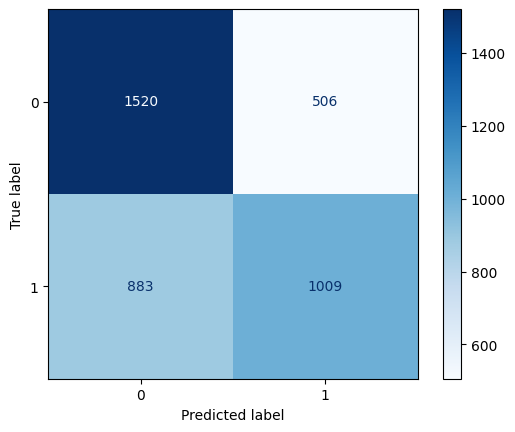

In [18]:
df['prediction'] = (df['probability'] >= best_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(df['win_side'], df['prediction'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

## Sensitivity Analysis

In [19]:
sensitivity  = recall_score(df['win_side'], df['prediction'], pos_label=1)
specificity  = recall_score(df['win_side'], df['prediction'], pos_label=0)
accuracy = accuracy_score(df['win_side'], df['prediction'])

print('sensitivity: ', sensitivity)
print('specificity: ', specificity)
print('accuracy: ', accuracy)

sensitivity:  0.5332980972515856
specificity:  0.7502467917077986
accuracy:  0.6454823889739663


## ROC Curve

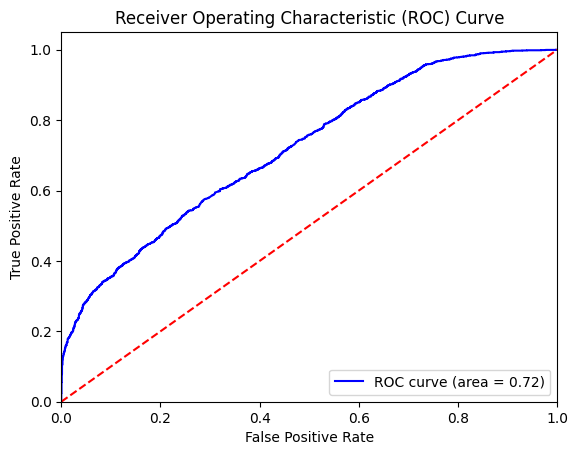

In [20]:
fpr, tpr, thresholds = roc_curve(df['win_side'], df['probability'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha de referência
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

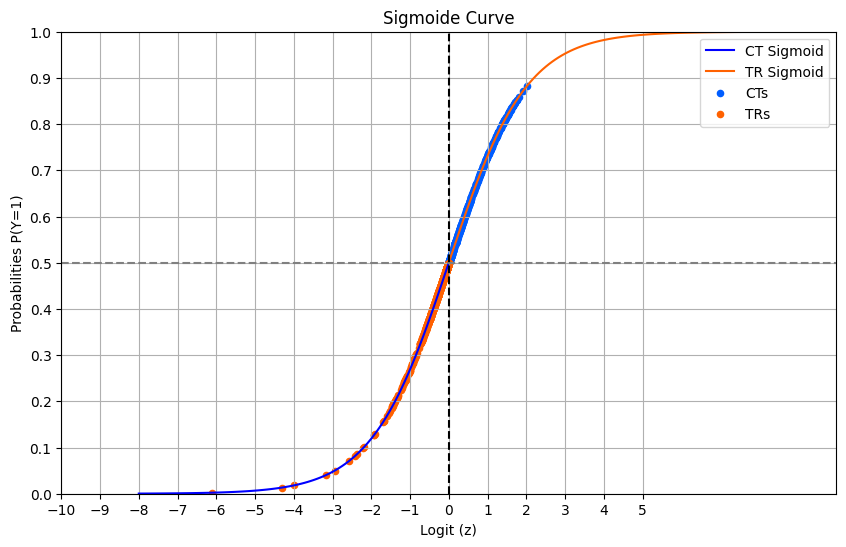

In [42]:
z_ct = np.linspace(-8, 0, 100)
z_tr = np.linspace(0, 8, 100)

probability_ct = 1 / (1 + np.exp(-z_ct))
probability_tr = 1 / (1 + np.exp(-z_tr))

final_model_params= final_model.params

df['logit'] = np.dot(x_predictions, final_model_params)

df_ct_errors = df[(df['probability'] > .5) & (df['win_side'] == 0)]
df_tr_errors = df[(df['probability'] < .5) & (df['win_side'] == 1)]

plt.figure(figsize=(10, 6))
plt.plot(z_ct, probability_ct, label='CT Sigmoid', color='#0000FF')
plt.plot(z_tr, probability_tr, label='TR Sigmoid', color='#FF6100')
plt.scatter(df_ct_errors['logit'], df_ct_errors['probability'], color='#005DFF', s=20, label='CTs')
plt.scatter(df_tr_errors['logit'], df_tr_errors['probability'], color='#FF6100', s=20, label='TRs')
plt.axhline(0.5, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.title('Sigmoide Curve')
plt.xlabel('Logit (z)')
plt.ylabel('Probabilities P(Y=1)')
plt.xlim(-10, 10)
plt.ylim(0, 1)
plt.xticks(np.arange(-10, 6, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.legend()
plt.show()